**Анализ защищенности систем искусственного интеллекта**

Практическое занятие №6 и Лабораторная работа №4

на тему: Изучение методов защиты от атак на модели НС

Гребенник Георгий ББМО-01-22

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)
print("Training data:",len(train_loader),"Validation data:",len(val_loader),"Test data:",len(test_loader))

100%|██████████| 9912422/9912422 [00:00<00:00, 82111399.50it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 89465061.91it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31326511.98it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21821911.53it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Training data: 50000 Validation data: 10000 Test data: 10000


In [3]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

In [4]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

In [5]:
model = Net().to(device)

In [6]:
optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [7]:
def fit(model,device,train_loader,val_loader,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label = data[0].to(device),data[1].to(device)
        output = model(input)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

In [8]:
loss, val_loss = fit(model, device, train_loader, val_loader, 10)

Fitting the model...


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 1 Loss: 0.2850503676612788 Val_Loss: 0.1465472458492094
Epoch: 2 Loss: 0.11141908125931078 Val_Loss: 0.11816810167795906
Epoch: 3 Loss: 0.08508949297238538 Val_Loss: 0.10610676416118986
Epoch: 4 Loss: 0.07273402502575843 Val_Loss: 0.08871200382142519
Epoch: 5 Loss: 0.0640585860067484 Val_Loss: 0.08652106153088714
Epoch: 6 Loss: 0.0607716777421671 Val_Loss: 0.08539433175660129
Epoch: 7 Loss: 0.0562644432195245 Val_Loss: 0.07379816616976491
Epoch: 8 Loss: 0.053677760184325574 Val_Loss: 0.07861828822329812
Epoch: 9 Loss: 0.052243182574612974 Val_Loss: 0.07426569758173895
Epoch: 10 Loss: 0.050123429469401834 Val_Loss: 0.07791693960269636


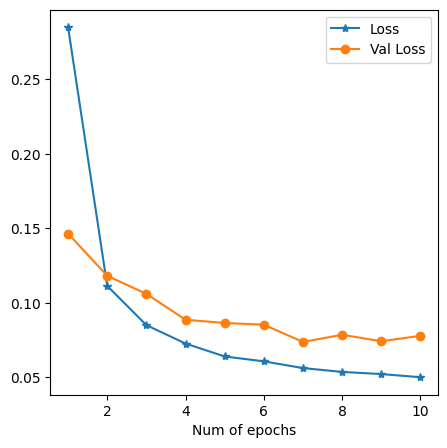

In [9]:
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,11), loss, "*-",label="Loss")
plt.plot(np.arange(1,11), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()

In [10]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

In [11]:
def ifgsm_attack(input,epsilon,data_grad):
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out


In [12]:
def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

In [13]:
def test(model,device,test_loader,epsilon,attack):
  correct = 0
  adv_examples = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1]
    if init_pred.item() != target.item():
      continue
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    if attack == "fgsm":
      perturbed_data = fgsm_attack(data,epsilon,data_grad)
    elif attack == "ifgsm":
      perturbed_data = ifgsm_attack(data,epsilon,data_grad)
    elif attack == "mifgsm":
      perturbed_data = mifgsm_attack(data,epsilon,data_grad)
    output = model(perturbed_data)
    final_pred = output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
      correct += 1
    if (epsilon == 0) and (len(adv_examples) < 5):
      adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
      adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    else:
      if len(adv_examples) < 5:
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
  return final_acc, adv_examples


Epsilon: 0	Test Accuracy = 9730 / 10000 = 0.973
Epsilon: 0.007	Test Accuracy = 9706 / 10000 = 0.9706
Epsilon: 0.01	Test Accuracy = 9674 / 10000 = 0.9674
Epsilon: 0.02	Test Accuracy = 9650 / 10000 = 0.965
Epsilon: 0.03	Test Accuracy = 9592 / 10000 = 0.9592
Epsilon: 0.05	Test Accuracy = 9436 / 10000 = 0.9436
Epsilon: 0.1	Test Accuracy = 8778 / 10000 = 0.8778
Epsilon: 0.2	Test Accuracy = 6428 / 10000 = 0.6428
Epsilon: 0.3	Test Accuracy = 4143 / 10000 = 0.4143


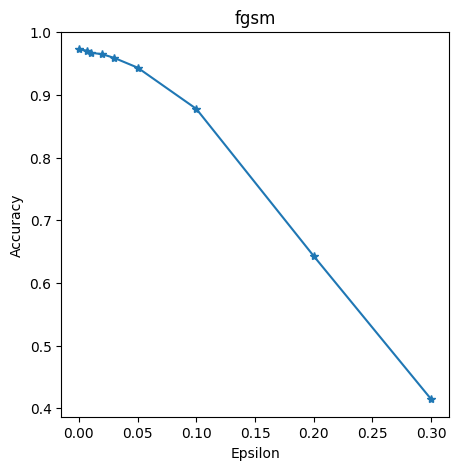

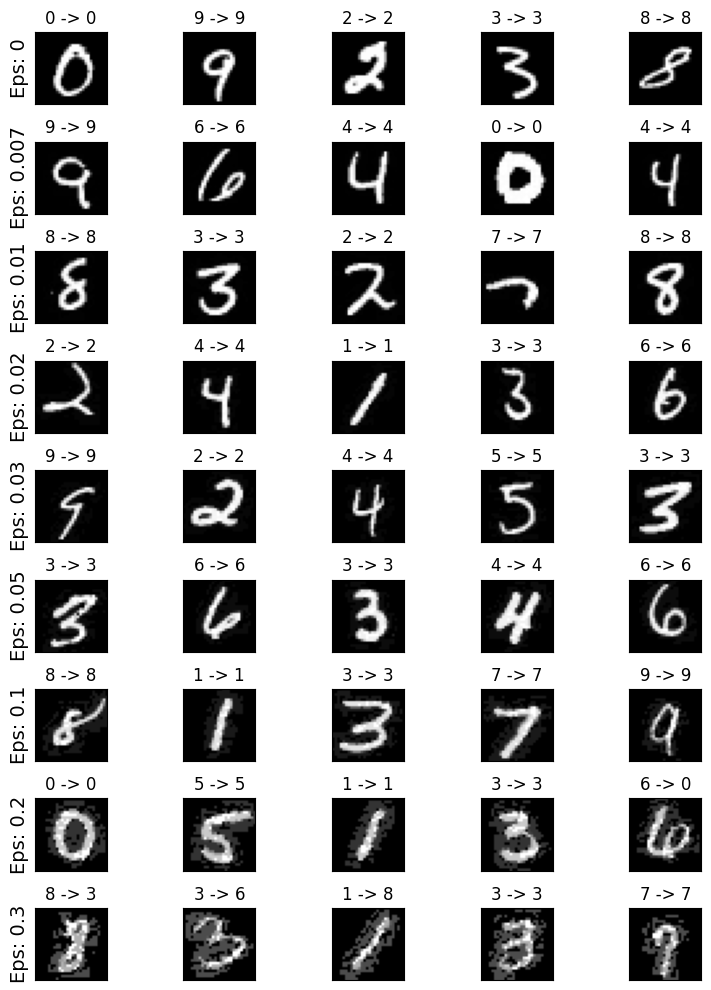

Epsilon: 0	Test Accuracy = 9729 / 10000 = 0.9729
Epsilon: 0.007	Test Accuracy = 9709 / 10000 = 0.9709
Epsilon: 0.01	Test Accuracy = 9699 / 10000 = 0.9699
Epsilon: 0.02	Test Accuracy = 9659 / 10000 = 0.9659
Epsilon: 0.03	Test Accuracy = 9606 / 10000 = 0.9606
Epsilon: 0.05	Test Accuracy = 9477 / 10000 = 0.9477
Epsilon: 0.1	Test Accuracy = 8936 / 10000 = 0.8936
Epsilon: 0.2	Test Accuracy = 6912 / 10000 = 0.6912
Epsilon: 0.3	Test Accuracy = 4839 / 10000 = 0.4839


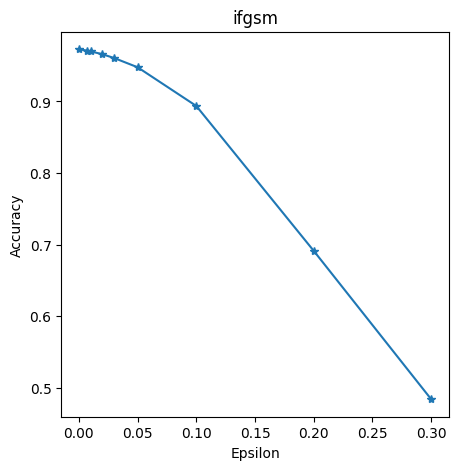

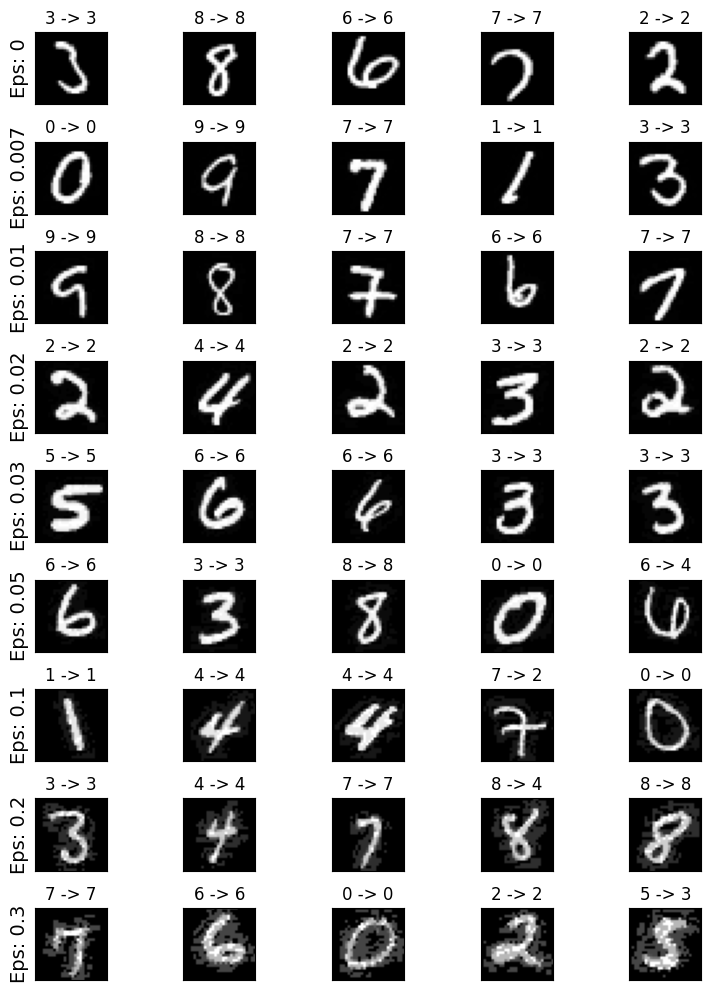

Epsilon: 0	Test Accuracy = 9708 / 10000 = 0.9708
Epsilon: 0.007	Test Accuracy = 9706 / 10000 = 0.9706
Epsilon: 0.01	Test Accuracy = 9694 / 10000 = 0.9694
Epsilon: 0.02	Test Accuracy = 9646 / 10000 = 0.9646
Epsilon: 0.03	Test Accuracy = 9601 / 10000 = 0.9601
Epsilon: 0.05	Test Accuracy = 9494 / 10000 = 0.9494
Epsilon: 0.1	Test Accuracy = 8953 / 10000 = 0.8953
Epsilon: 0.2	Test Accuracy = 6999 / 10000 = 0.6999
Epsilon: 0.3	Test Accuracy = 4797 / 10000 = 0.4797


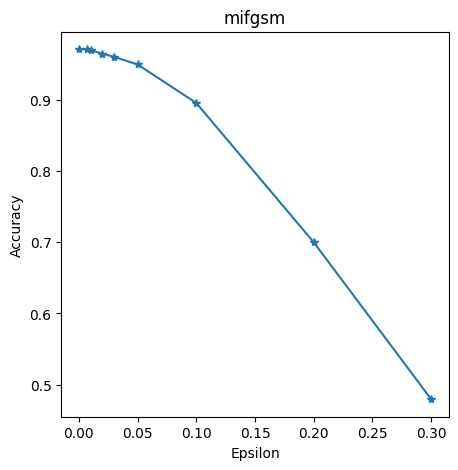

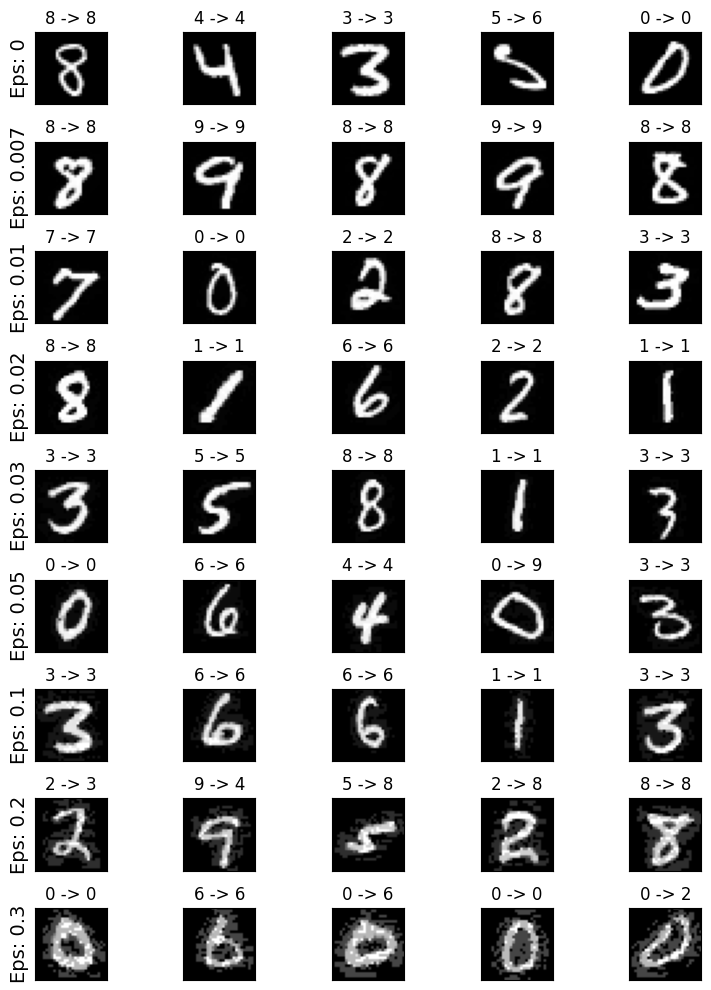

In [14]:
epsilons = [0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
for attack in ("fgsm","ifgsm","mifgsm"):
  accuracies = []
  examples = []
  for eps in epsilons:
    acc, ex = test(model, device,test_loader,eps,attack)
    accuracies.append(acc)
    examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()
  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
    for j in range(len(examples[i])):
      cnt += 1
      plt.subplot(len(epsilons),len(examples[0]),cnt)
      plt.xticks([], [])
      plt.yticks([], [])
      if j == 0:
        plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
      orig,adv,ex = examples[i][j]
      plt.title("{} -> {}".format(orig, adv))
      plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

In [15]:
class NetF(nn.Module):
  def __init__(self):
    super(NetF, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

In [16]:
class NetF1(nn.Module):
  def __init__(self):
    super(NetF1, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(4608, 64)
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x


In [17]:
def fit(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label = data[0].to(device),data[1].to(device)
        output = model(input)
        output = F.log_softmax(output/Temp,dim=1)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
      else:
        val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

  def test(model,device,test_loader,epsilon,Temp,attack):
    correct=0
    adv_examples = []
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      data.requires_grad = True
      output = model(data)
      output = F.log_softmax(output/Temp,dim=1)
      init_pred = output.max(1, keepdim=True)[1]
      if init_pred.item() != target.item():
        continue
      loss = F.nll_loss(output, target)
      model.zero_grad()
      loss.backward()
      data_grad = data.grad.data
      if attack == "fgsm":
        perturbed_data = fgsm_attack(data,epsilon,data_grad)
      elif attack == "ifgsm":
        perturbed_data = ifgsm_attack(data,epsilon,data_grad)
      elif attack == "mifgsm":
        perturbed_data = mifgsm_attack(data,epsilon,data_grad)
      output = model(perturbed_data)
      final_pred = output.max(1, keepdim=True)[1]
      if final_pred.item() == target.item():
        correct += 1
        if (epsilon == 0) and (len(adv_examples) < 5):
          adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
          adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
          if len(adv_examples) < 5:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
  return final_acc,adv_examples

In [18]:

def defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons):
  modelF = NetF().to(device)
  optimizerF = optim.Adam(modelF.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF = optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode='min', factor=0.1, patience=3)
  modelF1 = NetF1().to(device)
  optimizerF1 = optim.Adam(modelF1.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF1 = optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode='min', factor=0.1, patience=3)
  criterion = nn.NLLLoss()
  lossF,val_lossF=fit(modelF,device,optimizerF,schedulerF,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF,"o-",label="Val Loss")
  plt.title("Network F")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()
  #converting target labels to soft labels
  for data in train_loader:
    input, label = data[0].to(device),data[1].to(device)
    softlabel = F.log_softmax(modelF(input),dim=1)
    data[1] = softlabel
  lossF1,val_lossF1=fit(modelF1,device,optimizerF1,schedulerF1,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF1, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF1,"o-",label="Val Loss")
  plt.title("Network F'")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()
  model = NetF1().to(device)
  model.load_state_dict(modelF1.state_dict())
  for attack in ("fgsm","ifgsm","mifgsm"):
    accuracies = []
    examples = []
    for eps in epsilons:
      acc, ex = test(model,device,test_loader,eps,"fgsm")
      accuracies.append(acc)
      examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()
  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
    for j in range(len(examples[i])):
      cnt += 1
      plt.subplot(len(epsilons),len(examples[0]),cnt)
      plt.xticks([], [])
      plt.yticks([], [])
      if j == 0:
        plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
      orig,adv,ex = examples[i][j]
      plt.title("{} -> {}".format(orig, adv))
      plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

Fitting the model...
Epoch: 1 Loss: 0.5481338738800597 Val_Loss: 1.003228621557355e-05
Epoch: 2 Loss: 0.3353229173747994 Val_Loss: 0.00045950331687927244
Epoch: 3 Loss: 0.26381421273058636 Val_Loss: 0.00011647366284596501
Epoch: 4 Loss: 0.2061726351569701 Val_Loss: 0.00046973809078335765
Epoch: 5 Loss: 0.16251364960605083 Val_Loss: 4.2924879031488676e-06
Epoch: 6 Loss: 0.13502419098830928 Val_Loss: 1.265520486049354e-06
Epoch: 7 Loss: 0.11464148852530506 Val_Loss: 1.9935742660891264e-06
Epoch: 8 Loss: 0.10202881376955898 Val_Loss: 8.956958248745651e-06
Epoch: 9 Loss: 0.09666660607148457 Val_Loss: 1.391292948028422e-07
Epoch: 10 Loss: 0.09198299259128082 Val_Loss: 2.5270764308515935e-08


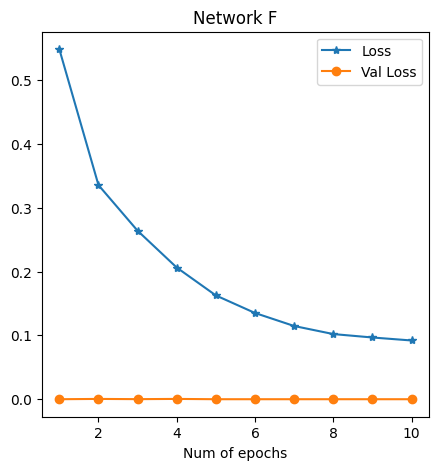

Fitting the model...
Epoch: 1 Loss: 0.6784468315404466 Val_Loss: 7.445180974900722e-05
Epoch: 2 Loss: 0.4882124064700297 Val_Loss: 1.9082169979810715e-05
Epoch: 3 Loss: 0.4424660353774885 Val_Loss: 1.618420109152794e-05
Epoch: 4 Loss: 0.40715175550074595 Val_Loss: 6.557496637105942e-05
Epoch: 5 Loss: 0.3757558067303607 Val_Loss: 0.00021618845984339714
Epoch: 6 Loss: 0.3397686602646741 Val_Loss: 2.1136321491212584e-05
Epoch: 7 Loss: 0.2946280665979756 Val_Loss: 7.914992245787288e-06
Epoch: 8 Loss: 0.260406978453543 Val_Loss: 2.3180012707598506e-06
Epoch: 9 Loss: 0.23156262885010914 Val_Loss: 2.070512989848794e-06
Epoch: 10 Loss: 0.20667021672648633 Val_Loss: 1.3112946021465177e-09


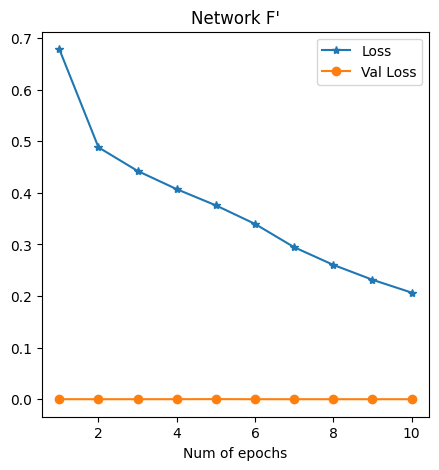

Epsilon: 0	Test Accuracy = 9119 / 10000 = 0.9119
Epsilon: 0.007	Test Accuracy = 9147 / 10000 = 0.9147
Epsilon: 0.01	Test Accuracy = 9026 / 10000 = 0.9026
Epsilon: 0.02	Test Accuracy = 9036 / 10000 = 0.9036
Epsilon: 0.03	Test Accuracy = 8931 / 10000 = 0.8931
Epsilon: 0.05	Test Accuracy = 8782 / 10000 = 0.8782
Epsilon: 0.1	Test Accuracy = 8024 / 10000 = 0.8024
Epsilon: 0.2	Test Accuracy = 4639 / 10000 = 0.4639
Epsilon: 0.3	Test Accuracy = 1817 / 10000 = 0.1817
Epsilon: 0	Test Accuracy = 9119 / 10000 = 0.9119
Epsilon: 0.007	Test Accuracy = 9063 / 10000 = 0.9063
Epsilon: 0.01	Test Accuracy = 9114 / 10000 = 0.9114
Epsilon: 0.02	Test Accuracy = 8996 / 10000 = 0.8996
Epsilon: 0.03	Test Accuracy = 8926 / 10000 = 0.8926
Epsilon: 0.05	Test Accuracy = 8778 / 10000 = 0.8778
Epsilon: 0.1	Test Accuracy = 7991 / 10000 = 0.7991
Epsilon: 0.2	Test Accuracy = 4662 / 10000 = 0.4662
Epsilon: 0.3	Test Accuracy = 1852 / 10000 = 0.1852
Epsilon: 0	Test Accuracy = 9113 / 10000 = 0.9113
Epsilon: 0.007	Test Accur

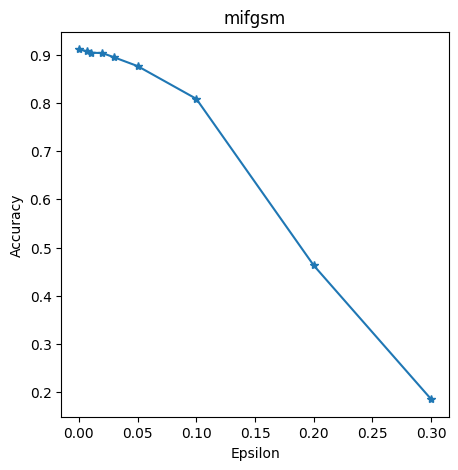

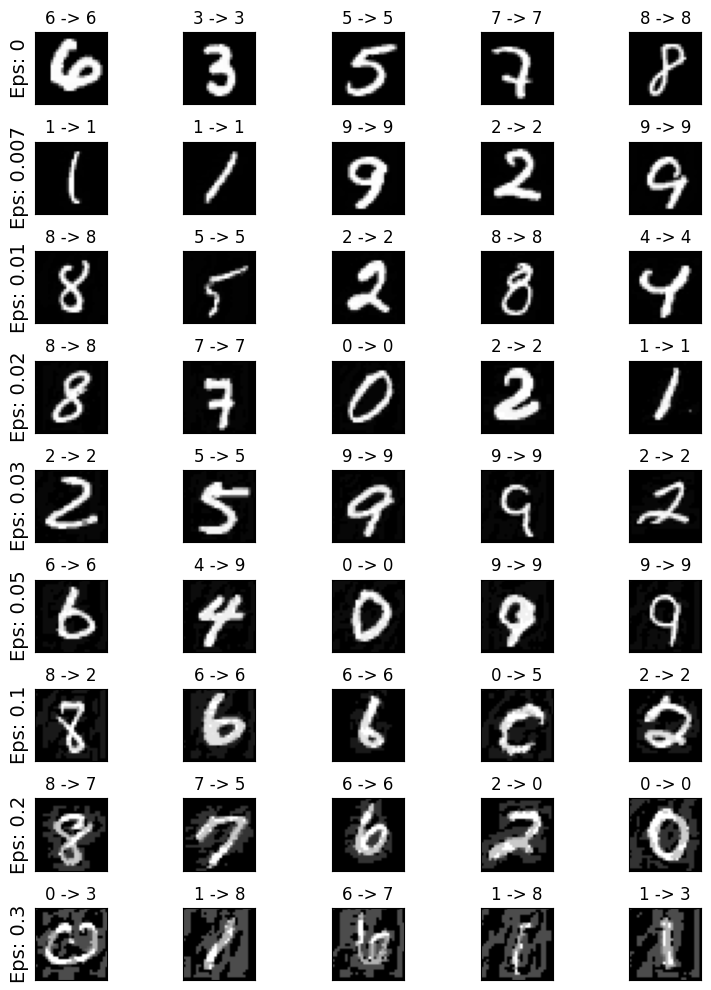

In [19]:
Temp=100
epochs=10
epsilons=[0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons)